In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import os
os.getcwd()

In [2]:
# from IPython.display import IFrame
# IFrame(src='https://www.kaggle.com/c/spaceship-titanic', width=1500, height=800)

# **Introduction**


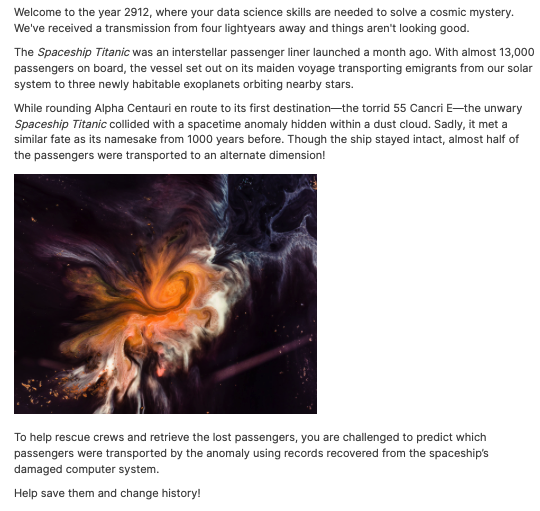

In [3]:
from IPython.display import Image
Image("Kaggle SpashipTitanic.png")

This kernel was inspired in part by the work of [SarahG](https://www.kaggle.com/sgus1318/titanic-analysis-learning-to-swim-with-python)'s analysis that I thank very much for the quality of her analysis. This work represents a deeper analysis by playing on several parameters while using only logistic regression estimator. In a future work, I will discuss other techniques. I am open to any criticism and proposal. You do not hesitate to evaluate this analysis.
The following kernel contains the steps enumerated below for assessing the Titanic survival dataset:

1. [Import data and python packages](#t1.)
2. [Assess Data Quality & Missing Values](#t2.)
    * 2.1. [Age - Missing Values](#t2.1.)
    * 2.2. [Cabin - Missing Values](#t2.2.)
    * 2.3. [Embarked - Missing Values](#t2.3.)
    * 2.4. [Final Adjustments to Data](#t2.4.)
        * 2.4.1 [Additional Variables](#t2.4.1.)
3. [Exploratory Data Analysis](#t3.)
4. [Logistic Regression and Results](#t4.)
    * 4.1. [Feature selection](#t4.1.)
        * 4.1.1. [Recursive feature elimination](#t4.1.1.)
        * 4.1.2. [Feature ranking with recursive feature elimination and cross-validation](#t4.1.2.)
    * 4.2. [Review of model evaluation procedures](#t4.2.)
        * 4.2.1. [Model evaluation based on simple train/test split using `train_test_split()`](#t4.2.1.)
        * 4.2.2. [Model evaluation based on K-fold cross-validation using `cross_val_score()`](#t4.2.2.)
        * 4.2.3. [Model evaluation based on K-fold cross-validation using `cross_validate()`](#t4.2.3.)
    * 4.3. [GridSearchCV evaluating using multiple scorers simultaneously](#t4.3.)
    * 4.4. [GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline for preprocessing simultaneously](#t4.4.)

<a id="t1."></a>
# 1. Import Data & Python Packages

In [2]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [3]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("test.csv")

# # Read CSV test data file into DataFrame
# test_df = pd.read_csv("test.csv") ## No "Transported" values

# # preview train data
# train_df.head(10)

In [34]:
train_df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

In [7]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 8693.


In [6]:
train_df.describe() #Checking digital values statistics
## Create a column showing total spending
## Create a column showing if spend at all or not
## Create a column spend 1-100, 100-500, 500-1000, 1000-5000, 5000-10000 - 
## galima bandyti paieskoti optimaliu reziu su klasifikacija arba su K-means
## Pakulti klasterius pagal turimus duomenis ir juos taip pat itraukti i regresija, arba sukurti atskira regresija

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

In [9]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 4277.


<font color=red>  Note: there is no target variable into test data (i.e. "Transported" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression. </font>

<a id="t2."></a>
# 2. Data Quality & Missing Value Assessment

In [7]:
train_df.shape[0]

4277

In [8]:
#General info of train_df data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [35]:
# check missing values in train data
train_df.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [10]:
train_df_no_na=train_df.dropna()
print(train_df_no_na.shape[0]/train_df.shape[0]*100)

76.71264905307459


24% duomenų atkrinta dėl trūkstamų duomenų

<a id="t2.1."></a>
## 2.1.    Age - Missing Values

In [11]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 2.13%


~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.

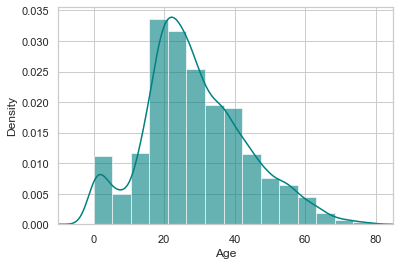

In [15]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values. 

In [16]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 28.83
The median of "Age" is 27.00


<a id="t2.2."></a>
## 2.2. Cabin - Missing Values

In [17]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 2.29%


Only 2,29 of records are missing, which let us to use this column as valid variable in regression analysis. These value will not be artificially updated because it is interesting would the cabin possition was important in survival rate in Spaceship travel.

<a id="t2.3."></a>
## 2.3. Embarked - Missing Values

In [18]:
# percent of missing "HomePlanet" 
print('Percent of missing "Homet Planet" records is %.2f%%' %((train_df['HomePlanet'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Homet Planet" records is 2.31%


There are  201 (2.31%) missing values for "HomePlanet", so we can just impute with the HomePlanet where most people boarded 

In [36]:
# print('Boarded passengers grouped by port of home planet (green = Europe, Orange = Earth, Blue = Mars):')
# print(train_df['HomePlanet'].value_counts())
# sns.countplot(x='HomePlanet', hue='Transported', data=train_df, palette='Set2')
# plt.show()

In [37]:
# # print('Boarded passengers grouped by destination)
# #       green = Europe, Orange = Earth, Blue = Mars):')
# print(train_df['Destination'].value_counts())
# sns.countplot(x='Destination', hue='Transported', data=train_df, palette='Set2')
# plt.show()

In [21]:
print('The most common boarding port of embarkation is %s.' %train_df['HomePlanet'].value_counts().idxmax())

The most common boarding port of embarkation is Earth.


By far the most passengers boarded in Earth, so we'll impute those 201 NaN's w/ "Earth" in following steps.

<a id="t2.4."></a>
## 2.4. Final Adjustments to Data (Train & Test)

Based on my assessment of the missing values in the dataset, I'll make the following changes to the data:
* If "Age" is missing for a given row, I'll impute with 28 (median age).
* If "Embarked" is missing for a riven row, I'll impute with "S" (the most common boarding port).
* I'll ignore "Cabin" as a variable. There are too many missing values for imputation. Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [38]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["HomePlanet"].fillna(train_df['HomePlanet'].value_counts().idxmax(), inplace=True)

In [39]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep        93
Cabin           100
Destination      92
Age               0
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [40]:
# preview adjusted train data
train_data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

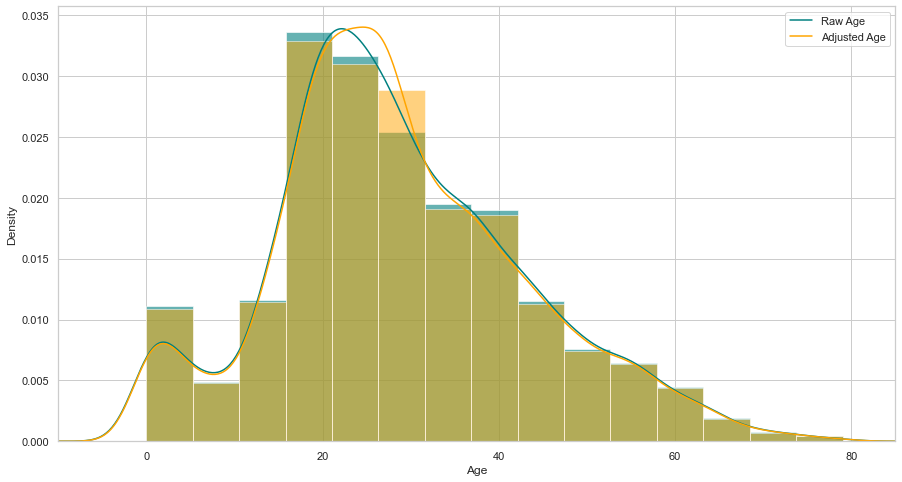

In [25]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [41]:
train_df.shape

(4277, 13)

In [42]:
# train_data_no_na=train_data.dropna()
# train_data_no_na.shape

In [44]:
# print(train_data_no_na.shape[0]/train_df.shape[0]*100)

Because adding median Age numbers and most common HomePlanet helped to lower data loss to 20 % and train_data will be used in following analysis as train_df after cleaning remaining na values

In [45]:
# #Data adter clearing na's
# train_data=train_data.dropna()
# train_data.shape

In [46]:
# train_data.head()

In [54]:
train_data.isnull().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Cabin               0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name                0
TotalExpenditure    0
Cabin_class         0
dtype: int64

In [50]:
# train_data = train_df.copy()
train_data["RoomService"].fillna(train_df["RoomService"].median(skipna=True), inplace=True)
train_data["FoodCourt"].fillna(train_df["FoodCourt"].median(skipna=True), inplace=True)
train_data["ShoppingMall"].fillna(train_df["ShoppingMall"].median(skipna=True), inplace=True)
train_data["Spa"].fillna(train_df["Spa"].median(skipna=True), inplace=True)
train_data["VRDeck"].fillna(train_df["VRDeck"].median(skipna=True), inplace=True)

train_data["CryoSleep"].fillna(train_df['CryoSleep'].value_counts().idxmax(), inplace=True)
train_data["VIP"].fillna(train_df['VIP'].value_counts().idxmax(), inplace=True)
train_data["Cabin"].fillna(train_df['Cabin'].value_counts().idxmax(), inplace=True)
train_data["Destination"].fillna(train_df['Destination'].value_counts().idxmax(), inplace=True)
train_data["Name"].fillna(train_df['Name'].value_counts().idxmax(), inplace=True)

<a id="t2.4.1."></a>
## 2.4.1. Additional Variables

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family.  For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [51]:
## Create categorical variable for total expenditure
train_data['TotalExpenditure']=train_data['RoomService']+train_data['FoodCourt']+train_data['ShoppingMall']+train_data['Spa']+train_data['VRDeck']
train_data

PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth       True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth      False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa       True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa      False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth      False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...        ...       ...            ...   ...    ...   
4272     9266_02      Earth       True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth      False   G/160/P    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars       True   D/296/P    55 Cancri e  26.0  False   
4275     9273_01     Europa      False   D/297/P    TRAPPIST-1e  26.0  False   
4276     9277_01      Earth       True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  \
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez   
...           ...        ...           ...     ...     ...               ...   
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter   
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron   
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore   
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale   
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley   

      TotalExpenditure  
0                  0.0  
1               2832.0  
2                  0.0  
3               7418.0  
4                645.0  
...                ...  
4272               0.0  
4273            1018.0  
4274               0.0  
4275            3203.0  
4276               0.0  

[4277 rows x 14 columns]

In [33]:
# ## Droping the other columns representing money spent
# train_data.drop('RoomService', axis=1, inplace=True)
# train_data.drop('FoodCourt', axis=1, inplace=True)
# train_data.drop('ShoppingMall', axis=1, inplace=True)
# train_data.drop('Spa', axis=1, inplace=True)
# train_data.drop('VRDeck', axis=1, inplace=True)
# train_data

In [34]:
##Checking how many unique "Cabin" ids exist in the dataset
train_data.groupby(by='Cabin').count()

PassengerId  HomePlanet  CryoSleep  Destination  Age  VIP  \
Cabin                                                                
A/0/P              2           2          2            2    2    2   
A/0/S              2           2          2            2    2    2   
A/1/S              3           3          3            3    3    3   
A/10/P             1           1          1            1    1    1   
A/10/S             1           1          1            1    1    1   
...              ...         ...        ...          ...  ...  ...   
G/999/P            2           2          2            2    2    2   
G/999/S            2           2          2            2    2    2   
T/0/P              1           1          1            1    1    1   
T/1/P              1           1          1            1    1    1   
T/3/P              1           1          1            1    1    1   

         RoomService  FoodCourt  ShoppingMall  Spa  VRDeck  Name  Transported  \
Cabin                                                                           
A/0/P              2          2             2    2       2     2            2   
A/0/S              2          2             2    2       2     2            2   
A/1/S              3          3             3    3       3     3            3   
A/10/P             1          1             1    1       1     1            1   
A/10/S             1          1             1    1       1     1            1   
...              ...        ...           ...  ...     ...   ...          ...   
G/999/P            2          2             2    2       2     2            2   
G/999/S            2          2             2    2       2     2            2   
T/0/P              1          1             1    1       1     1            1   
T/1/P              1          1             1    1       1     1            1   
T/3/P              1          1             1    1       1     1            1   

         TotalExpenditure  
Cabin                      
A/0/P                   2  
A/0/S                   2  
A/1/S                   3  
A/10/P                  1  
A/10/S                  1  
...                   ...  
G/999/P                 2  
G/999/S                 2  
T/0/P                   1  
T/1/P                   1  
T/3/P                   1  

[5514 rows x 14 columns]

Because Cabin column has 5000 unique values, parcing the cabin to get cabin class

In [52]:
train_data['Cabin_class'] = train_data['Cabin'].str[0]
train_data

PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth       True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth      False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa       True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa      False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth      False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...        ...       ...            ...   ...    ...   
4272     9266_02      Earth       True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth      False   G/160/P    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars       True   D/296/P    55 Cancri e  26.0  False   
4275     9273_01     Europa      False   D/297/P    TRAPPIST-1e  26.0  False   
4276     9277_01      Earth       True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  \
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning   
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers   
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus   
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter   
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez   
...           ...        ...           ...     ...     ...               ...   
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter   
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron   
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore   
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale   
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley   

      TotalExpenditure Cabin_class  
0                  0.0           G  
1               2832.0           F  
2                  0.0           C  
3               7418.0           C  
4                645.0           F  
...                ...         ...  
4272               0.0           G  
4273            1018.0           G  
4274               0.0           D  
4275            3203.0           D  
4276               0.0           G  

[4277 rows x 15 columns]

In [36]:
# ## Create categorical variable for traveling alone
# train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
# train_data.drop('SibSp', axis=1, inplace=True)
# train_data.drop('Parch', axis=1, inplace=True)

Create categorical variables for Cabin Class ("Cabin_class"), Departure planet ("HomePlanet"), and Arrival station ("Destination"). 

In [53]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["CryoSleep","VIP", "Cabin_class","HomePlanet","Destination"])
# training.drop('Sex_female', axis=1, inplace=True)
# training.drop('PassengerId', axis=1, inplace=True)
# training.drop('Name', axis=1, inplace=True)
# training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

PassengerId  Cabin   Age  RoomService  FoodCourt  ShoppingMall     Spa  \
0     0013_01  G/3/S  27.0          0.0        0.0           0.0     0.0   
1     0018_01  F/4/S  19.0          0.0        9.0           0.0  2823.0   
2     0019_01  C/0/S  31.0          0.0        0.0           0.0     0.0   
3     0021_01  C/1/S  38.0          0.0     6652.0           0.0   181.0   
4     0023_01  F/5/S  20.0         10.0        0.0         635.0     0.0   

   VRDeck              Name  TotalExpenditure  ...  Cabin_class_E  \
0     0.0   Nelly Carsoning               0.0  ...              0   
1     0.0    Lerome Peckers            2832.0  ...              0   
2     0.0   Sabih Unhearfus               0.0  ...              0   
3   585.0  Meratz Caltilter            7418.0  ...              0   
4     0.0   Brence Harperez             645.0  ...              0   

   Cabin_class_F  Cabin_class_G  Cabin_class_T  HomePlanet_Earth  \
0              0              1              0                 1   
1              1              0              0                 1   
2              0              0              0                 0   
3              0              0              0                 0   
4              1              0              0                 1   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                  0                0                        0   
1                  0                0                        0   
2                  1                0                        1   
3                  1                0                        0   
4                  0                0                        0   

   Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
0                          0                        1  
1                          0                        1  
2                          0                        0  
3                          0                        1  
4                          0                        1  

[5 rows x 28 columns]

### Now, apply the same changes to the test data. <br>
I will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28).  <br> I'll also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis. <br> There were no missing values in the "Embarked" port variable. <br> I'll add the dummy variables to finalize the test set.  <br> Finally, I'll impute the 1 missing value for "Fare" with the median, 14.45.

In [55]:
final_train.shape

(4277, 28)

In [59]:
final_train.isnull().sum()

PassengerId                  0
Cabin                        0
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                         0
TotalExpenditure             0
CryoSleep_False              0
CryoSleep_True               0
VIP_False                    0
VIP_True                     0
Cabin_class_A                0
Cabin_class_B                0
Cabin_class_C                0
Cabin_class_D                0
Cabin_class_E                0
Cabin_class_F                0
Cabin_class_G                0
Cabin_class_T                0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

In [40]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["HomePlanet"].fillna(train_df['HomePlanet'].value_counts().idxmax(), inplace=True)

test_data['TotalExpenditure']=test_data['RoomService']+test_data['FoodCourt']+test_data['ShoppingMall']+test_data['Spa']+test_data['VRDeck']
train_data

test_data.drop('RoomService', axis=1, inplace=True)
test_data.drop('FoodCourt', axis=1, inplace=True)
test_data.drop('ShoppingMall', axis=1, inplace=True)
test_data.drop('Spa', axis=1, inplace=True)
test_data.drop('VRDeck', axis=1, inplace=True)
test_data

test_data['Cabin_class'] = test_data['Cabin'].str[0]

In [41]:
test_data_no_na=test_data.dropna()
test_data_no_na.shape

(3415, 10)

In [42]:
test_data=test_data_no_na

In [43]:
testing=pd.get_dummies(test_data, columns=["CryoSleep", "VIP", "Cabin_class","HomePlanet","Destination"])
final_test = testing
final_test.head()

PassengerId  Cabin   Age              Name  TotalExpenditure  \
0     0013_01  G/3/S  27.0   Nelly Carsoning               0.0   
1     0018_01  F/4/S  19.0    Lerome Peckers            2832.0   
2     0019_01  C/0/S  31.0   Sabih Unhearfus               0.0   
3     0021_01  C/1/S  38.0  Meratz Caltilter            7418.0   
4     0023_01  F/5/S  20.0   Brence Harperez             645.0   

   CryoSleep_False  CryoSleep_True  VIP_False  VIP_True  Cabin_class_A  ...  \
0                0               1          1         0              0  ...   
1                1               0          1         0              0  ...   
2                0               1          1         0              0  ...   
3                1               0          1         0              0  ...   
4                1               0          1         0              0  ...   

   Cabin_class_E  Cabin_class_F  Cabin_class_G  Cabin_class_T  \
0              0              0              1              0   
1              0              1              0              0   
2              0              0              0              0   
3              0              0              0              0   
4              0              1              0              0   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                 1                  0                0   
1                 1                  0                0   
2                 0                  1                0   
3                 0                  1                0   
4                 1                  0                0   

   Destination_55 Cancri e  Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
0                        0                          0                        1  
1                        0                          0                        1  
2                        1                          0                        0  
3                        0                          0                        1  
4                        0                          0                        1  

[5 rows x 23 columns]

<a id="t3."></a>
# 3. Exploratory Data Analysis of Training data

<a id="t3.1."></a>
## 3.1. Exploration of Age

In [22]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Transported == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Transported == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'Transported'

<Figure size 1080x576 with 0 Axes>

The age distribution for survivors and deceased is actually very similar.  One notable difference is that, of the survivors, a larger proportion were children.  The passengers evidently made an attempt to save children by giving them a place on the life rafts. 

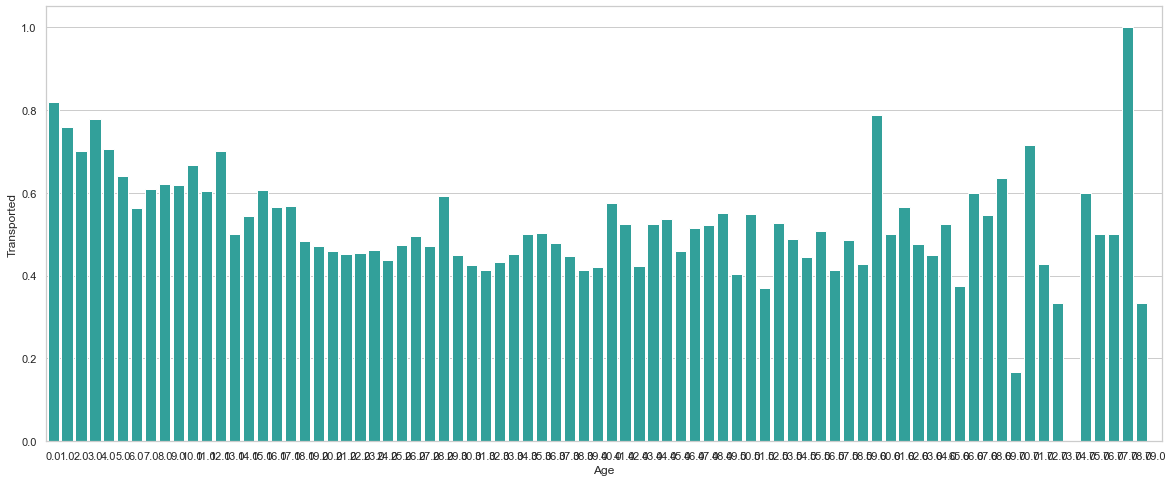

In [45]:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Transported"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Transported', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

Considering the survival rate of passengers under 16, I'll also include another categorical variable in my dataset: "Minor"

In [46]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)
final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

<a id="t3.2."></a>
## 3.2. Exploration of Fare

In [57]:
final_train.head()

PassengerId  Cabin   Age  RoomService  FoodCourt  ShoppingMall     Spa  \
0     0013_01  G/3/S  27.0          0.0        0.0           0.0     0.0   
1     0018_01  F/4/S  19.0          0.0        9.0           0.0  2823.0   
2     0019_01  C/0/S  31.0          0.0        0.0           0.0     0.0   
3     0021_01  C/1/S  38.0          0.0     6652.0           0.0   181.0   
4     0023_01  F/5/S  20.0         10.0        0.0         635.0     0.0   

   VRDeck              Name  TotalExpenditure  ...  Cabin_class_E  \
0     0.0   Nelly Carsoning               0.0  ...              0   
1     0.0    Lerome Peckers            2832.0  ...              0   
2     0.0   Sabih Unhearfus               0.0  ...              0   
3   585.0  Meratz Caltilter            7418.0  ...              0   
4     0.0   Brence Harperez             645.0  ...              0   

   Cabin_class_F  Cabin_class_G  Cabin_class_T  HomePlanet_Earth  \
0              0              1              0                 1   
1              1              0              0                 1   
2              0              0              0                 0   
3              0              0              0                 0   
4              1              0              0                 1   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                  0                0                        0   
1                  0                0                        0   
2                  1                0                        1   
3                  1                0                        0   
4                  0                0                        0   

   Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
0                          0                        1  
1                          0                        1  
2                          0                        0  
3                          0                        1  
4                          0                        1  

[5 rows x 28 columns]

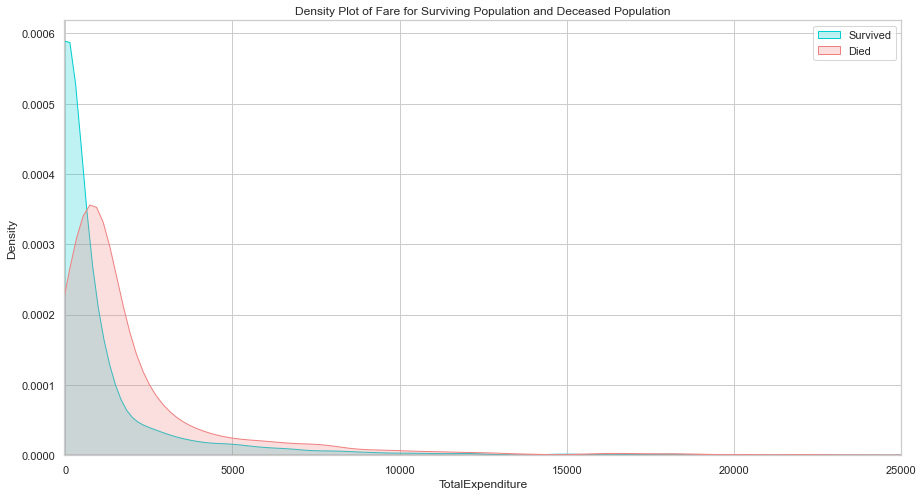

In [48]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["TotalExpenditure"][final_train.Transported == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["TotalExpenditure"][final_train.Transported == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='TotalExpenditure')
plt.xlim(-20,25000)
plt.show()

More likely to transport the ones who didint have additional expenditure.

<a id="t3.3."></a>
## 3.3. Exploration of Passenger Class

In [23]:
sns.barplot('Cabin_class', 'Transported', data=train_data, color="darkturquoise")
plt.show()

ValueError: Could not interpret input 'Transported'

Being in A, B, C, G was safest.

<a id="t3.4."></a>
## 3.4. Exploration of  Home Planet

In [24]:
sns.barplot('HomePlanet', 'Transported', data=train_df, color="teal")
plt.show()

ValueError: Could not interpret input 'Transported'

In [51]:
# Passengers who boarded in Cherbourg, France, appear to have the highest survival rate.  Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown.  This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck). <br> It's also worth noting the size of the whiskers in these plots.  Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest.  The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker.  It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.

<a id="t3.5."></a>
## 3.5. Exploration om VIP

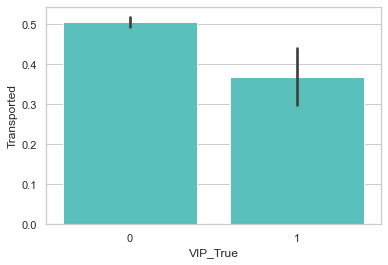

In [52]:
sns.barplot('VIP_True', 'Transported', data=final_train, color="mediumturquoise")
plt.show()

Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

<a id="t3.6."></a>
## 3.6. Exploration of Gender Variable

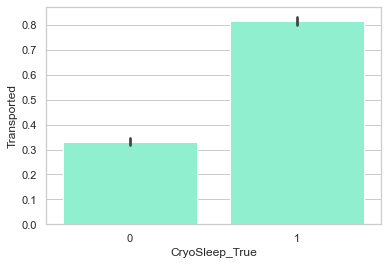

In [53]:
    sns.barplot('CryoSleep_True', 'Transported', data=final_train, color="aquamarine")
plt.show()

Cryo sleep greatly increased your chances of survival.

<a id="t4."></a>
# 4. Logistic Regression and Results

<a id="t4.1."></a>
## 4.1. Feature selection

<a id="t4.1.1."></a>
### 4.1.1. Recursive feature elimination

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_ attribute` or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References: <br>
http://scikit-learn.org/stable/modules/feature_selection.html <br>

In [58]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                4277 non-null   object 
 1   Cabin                      4277 non-null   object 
 2   Age                        4277 non-null   float64
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   Name                       4277 non-null   object 
 9   TotalExpenditure           4277 non-null   float64
 10  CryoSleep_False            4277 non-null   uint8  
 11  CryoSleep_True             4277 non-null   uint8  
 12  VIP_False                  4277 non-null   uint8  
 13  VIP_True                   4277 non-null   uint8

In [55]:
## Change CyroSleep and VIP values to numerical
# df["column1"].replace({"a": "x", "b": "y"}, inplace=True)
# print(df)
# final_train['CryoSleep_new']=final_train['CryoSleep'].replace({'True':1, 'False':0}, inplace=True)
# final_train

In [29]:
## Exporting data prepared for statistical analysis
final_train.to_csv("final_test_submission.csv", index=False)

In [57]:
# Read CSV final_train data file into DataFrame
final_train = pd.read_csv("final_train.csv")
final_train

PassengerId     Cabin   Age  RoomService  FoodCourt  ShoppingMall  \
0        0001_01     B/0/P  39.0          0.0        0.0           0.0   
1        0002_01     F/0/S  24.0        109.0        9.0          25.0   
2        0003_01     A/0/S  58.0         43.0     3576.0           0.0   
3        0003_02     A/0/S  33.0          0.0     1283.0         371.0   
4        0004_01     F/1/S  16.0        303.0       70.0         151.0   
...          ...       ...   ...          ...        ...           ...   
6916     9276_01    A/98/P  41.0          0.0     6819.0           0.0   
6917     9278_01  G/1499/S  18.0          0.0        0.0           0.0   
6918     9279_01  G/1500/S  26.0          0.0        0.0        1872.0   
6919     9280_01   E/608/S  32.0          0.0     1049.0           0.0   
6920     9280_02   E/608/S  44.0        126.0     4688.0           0.0   

         Spa  VRDeck               Name  Transported  ...  Cabin_class_F  \
0        0.0     0.0    Maham Ofracculy        False  ...              0   
1      549.0    44.0       Juanna Vines         True  ...              1   
2     6715.0    49.0      Altark Susent        False  ...              0   
3     3329.0   193.0       Solam Susent        False  ...              0   
4      565.0     2.0  Willy Santantines         True  ...              1   
...      ...     ...                ...          ...  ...            ...   
6916  1643.0    74.0  Gravior Noxnuther        False  ...              0   
6917     0.0     0.0    Kurta Mondalley        False  ...              0   
6918     1.0     0.0       Fayey Connon         True  ...              0   
6919   353.0  3235.0   Celeon Hontichre        False  ...              0   
6920     0.0    12.0   Propsh Hontichre         True  ...              0   

      Cabin_class_G  Cabin_class_T  HomePlanet_Earth  HomePlanet_Europa  \
0                 0              0                 0                  1   
1                 0              0                 1                  0   
2                 0              0                 0                  1   
3                 0              0                 0                  1   
4                 0              0                 1                  0   
...             ...            ...               ...                ...   
6916              0              0                 0                  1   
6917              1              0                 1                  0   
6918              1              0                 1                  0   
6919              0              0                 0                  1   
6920              0              0                 0                  1   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                   0                        0                          0   
1                   0                        0                          0   
2                   0                        0                          0   
3                   0                        0                          0   
4                   0                        0                          0   
...               ...                      ...                        ...   
6916                0                        1                          0   
6917                0                        0                          1   
6918                0                        0                          0   
6919                0                        1                          0   
6920                0                        0                          0   

      Destination_TRAPPIST-1e  IsMinor  
0                           1        0  
1                           1        0  
2                           1        0  
3                           1        0  
4                           1        1  
...                       ...      ...  
6916                        0        0  
6917                        0        0  
6918    

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["CryoSleep_False", "CryoSleep_True", "Age","TotalExpenditure","VIP_False", "VIP_True","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e", "IsMinor"] 
X = final_train[cols]
y = final_train['Transported']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, n_features_to_select=20)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))



Selected features: ['CryoSleep_False', 'CryoSleep_True', 'Age', 'TotalExpenditure', 'VIP_False', 'VIP_True', 'Cabin_class_A', 'Cabin_class_B', 'Cabin_class_C', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_F', 'Cabin_class_G', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'IsMinor']


<a id="t4.1.2."></a>
### 4.1.2. Feature ranking with recursive feature elimination and cross-validation

RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. Hereafter a recursive feature elimination applied on logistic regression with automatic tuning of the number of features selected with cross-validation.

Optimal number of features: 21
Selected features: ['CryoSleep_False', 'CryoSleep_True', 'Age', 'TotalExpenditure', 'VIP_False', 'VIP_True', 'Cabin_class_A', 'Cabin_class_B', 'Cabin_class_C', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_F', 'Cabin_class_G', 'Cabin_class_T', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'IsMinor']


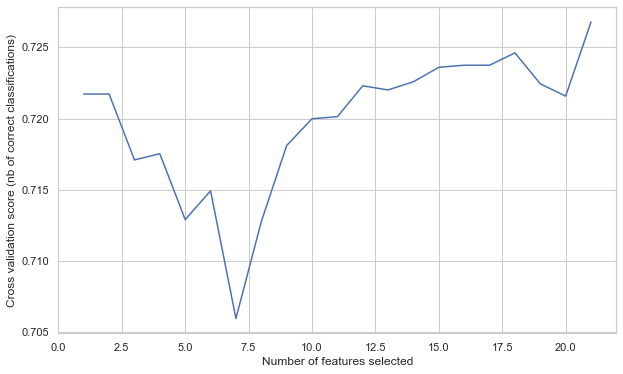

In [59]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

As we see, 21 variables were kept. 

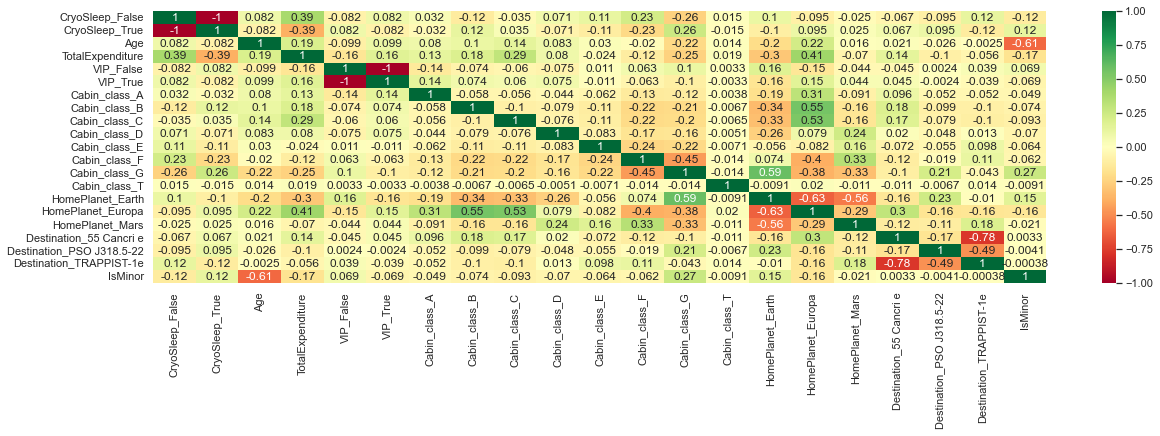

In [60]:
Selected_features = ["CryoSleep_False", "CryoSleep_True", "Age","TotalExpenditure","VIP_False", "VIP_True","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e", "IsMinor"]
X = final_train[Selected_features]

plt.subplots(figsize=(20, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Because of high correlation in between CryoSleep and VIP false and positive column removing False columns.

In [61]:
Selected_features = ["CryoSleep_True", "Age","TotalExpenditure","VIP_True","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e", "IsMinor"]

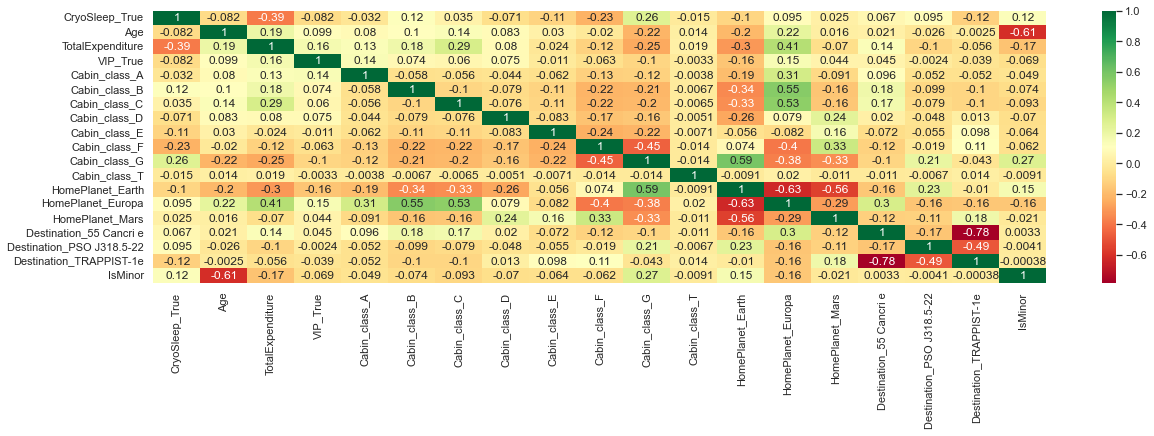

In [62]:
X = final_train[Selected_features]

plt.subplots(figsize=(20, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Kadangi yra nemaža koorialiacija tarp is minnor reikšmės ir age, tai is Minnor rodiklis išimamas, tai pagerina modelio progranozavimo kokybę.

In [63]:
Selected_features = ["CryoSleep_True", "Age","TotalExpenditure","VIP_True","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]

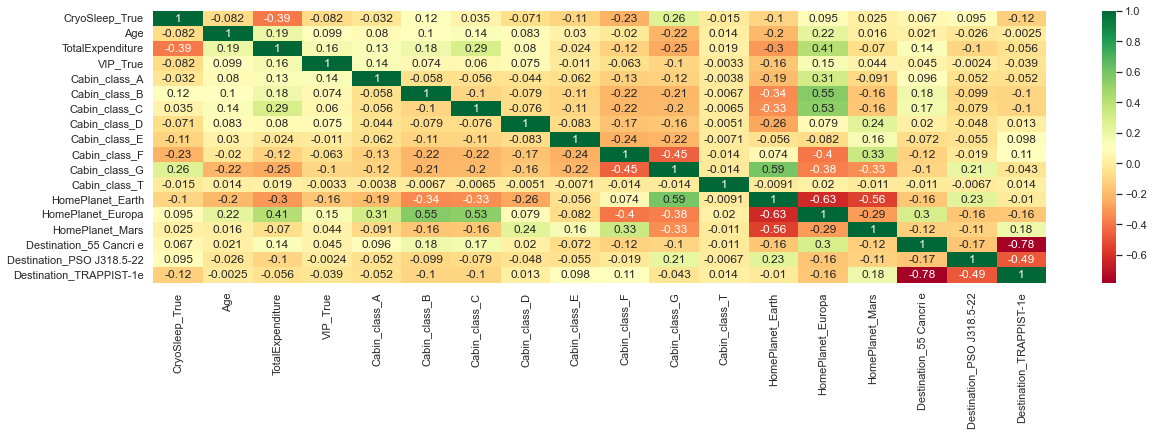

In [64]:
X = final_train[Selected_features]

plt.subplots(figsize=(20, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [65]:
Selected_features = ["CryoSleep_True", "Age","TotalExpenditure","VIP_True","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]

In [66]:
## After testing multicorrelation of the variables 
#in the model few variables are removed from the dataset to improve model prediction score

In [60]:
final_train=final_train.drop(columns=['CryoSleep_False', 'VIP_False'])

In [61]:
## Rename columns
final_train.rename(columns={'CryoSleep_True':'CryoSleep', 'VIP_True':'VIP'}, inplace=True)
final_train

PassengerId     Cabin   Age  RoomService  FoodCourt  ShoppingMall  \
0        0013_01     G/3/S  27.0          0.0        0.0           0.0   
1        0018_01     F/4/S  19.0          0.0        9.0           0.0   
2        0019_01     C/0/S  31.0          0.0        0.0           0.0   
3        0021_01     C/1/S  38.0          0.0     6652.0           0.0   
4        0023_01     F/5/S  20.0         10.0        0.0         635.0   
...          ...       ...   ...          ...        ...           ...   
4272     9266_02  G/1496/S  34.0          0.0        0.0           0.0   
4273     9269_01   G/160/P  42.0          0.0      847.0          17.0   
4274     9271_01   D/296/P  26.0          0.0        0.0           0.0   
4275     9273_01   D/297/P  26.0          0.0     2680.0           0.0   
4276     9277_01  G/1498/S  43.0          0.0        0.0           0.0   

         Spa  VRDeck              Name  TotalExpenditure  ...  Cabin_class_E  \
0        0.0     0.0   Nelly Carsoning               0.0  ...              0   
1     2823.0     0.0    Lerome Peckers            2832.0  ...              0   
2        0.0     0.0   Sabih Unhearfus               0.0  ...              0   
3      181.0   585.0  Meratz Caltilter            7418.0  ...              0   
4        0.0     0.0   Brence Harperez             645.0  ...              0   
...      ...     ...               ...               ...  ...            ...   
4272     0.0     0.0       Jeron Peter               0.0  ...              0   
4273    10.0   144.0     Matty Scheron            1018.0  ...              0   
4274     0.0     0.0       Jayrin Pore               0.0  ...              0   
4275     0.0   523.0    Kitakan Conale            3203.0  ...              0   
4276     0.0     0.0  Lilace Leonzaley               0.0  ...              0   

      Cabin_class_F  Cabin_class_G  Cabin_class_T  HomePlanet_Earth  \
0                 0              1              0                 1   
1                 1              0              0                 1   
2                 0              0              0                 0   
3                 0              0              0                 0   
4                 1              0              0                 1   
...             ...            ...            ...               ...   
4272              0              1              0                 1   
4273              0              1              0                 1   
4274              0              0              0                 0   
4275              0              0              0                 0   
4276              0              1              0                 1   

      HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                     0                0                        0   
1                     0                0                        0   
2                     1                0                        1   
3                     1                0                        0   
4                     0                0                        0   
...                 ...              ...                      ...   
4272                  0                0                        0   
4273                  0                0                        0   
4274                  0                1                        1   
4275                  1                0                        0   
4276                  0                0                        0   

      Destination_PSO J318.5-22  Destination_TRAPPIST-1e  
0                             0                        1  
1                             0                        1  
2                             0                        0  
3                             0                        1  
4                             0                        1  
...                         ...                      ...  
4272                          0                        1  
4

In [62]:
## Exporting data prepared for statistical analysis
final_train.to_csv("final_test_submission.csv", index=False)

In [70]:
Selected_features = ["CryoSleep", "Age","TotalExpenditure","VIP","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]

<a id="t4.2."></a>
## 4.2. Review of model evaluation procedures

Motivation: Need a way to choose between machine learning models
* Goal is to estimate likely performance of a model on out-of-sample data

Initial idea: Train and test on the same data
* But, maximizing training accuracy rewards overly complex models which overfit the training data

Alternative idea: Train/test split
* Split the dataset into two pieces, so that the model can be trained and tested on different data
* Testing accuracy is a better estimate than training accuracy of out-of-sample performance
* Problem with train/test split
    * It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
    * Testing accuracy can change a lot depending on a which observation happen to be in the testing set

Reference: <br>
http://www.ritchieng.com/machine-learning-cross-validation/ <br>

<a id="t4.2.1."></a>
### 4.2.1. Model evaluation based on simple train/test split using `train_test_split()` function (FINAL Train model spliting in train and test)

Train/Test split results:
LogisticRegression accuracy is 0.728
LogisticRegression log_loss is 0.546
LogisticRegression auc is 0.778


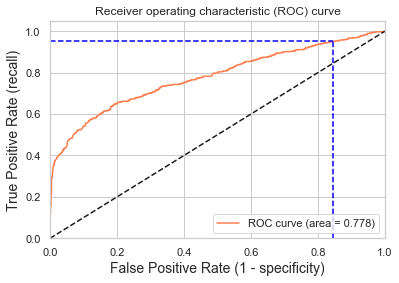

Using a threshold of 0.225 guarantees a sensitivity of 0.951 and a specificity of 0.155, i.e. a false positive rate of 84.46%.


In [71]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
X = final_train[Selected_features]
y = final_train['Transported']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

<a id="t4.2.2."></a>
### 4.2.1.1 Model evaluation based on KNeighborsClassifier

In [72]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=4,metric="minkowski")
knn.fit(X_train,y_train)
knn_pred=knn.predict(X_test)
accuracy_score(knn_pred,y_test)

0.7097472924187725

<a id="t4.2.2."></a>
### 4.2.2. Model evaluation based on K-fold cross-validation using `cross_val_score()` function 

In [73]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.726
LogisticRegression average log_loss is 0.549
LogisticRegression average auc is 0.777


<a id="t4.2.3."></a>
### 4.2.3. Model evaluation based on K-fold cross-validation using `cross_validate()` function 

In [74]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.726 (+/-0.012)
LogisticRegression average log_loss: 0.549 (+/-0.013)
LogisticRegression average auc: 0.777 (+/-0.016)


In [75]:
# <font color=bleu>What happens when we add the feature "Fare"?<font>

In [76]:
# cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"]
# X = final_train[cols]

# scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

# modelCV = LogisticRegression()

# results = cross_validate(modelCV, final_train[cols], y, cv=10, scoring=list(scoring.values()), 
#                          return_train_score=False)

# print('K-fold cross-validation results:')
# for sc in range(len(scoring)):
#     print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
#                                if list(scoring.values())[sc]=='neg_log_loss' 
#                                else results['test_%s' % list(scoring.values())[sc]].mean(), 
#                                results['test_%s' % list(scoring.values())[sc]].std()))

In [77]:
# <font color=red>We notice that the model is slightly deteriorated. The "Fare" variable does not carry any useful information. Its presence is just a noise for the logistic regression model.<font> 

<a id="t4.3."></a>
## 4.3. GridSearchCV evaluating using multiple scorers simultaneously

best params: LogisticRegression(C=2.4000100000000004)
best params: {'C': 2.4000100000000004}
best score: 0.7283629023513416


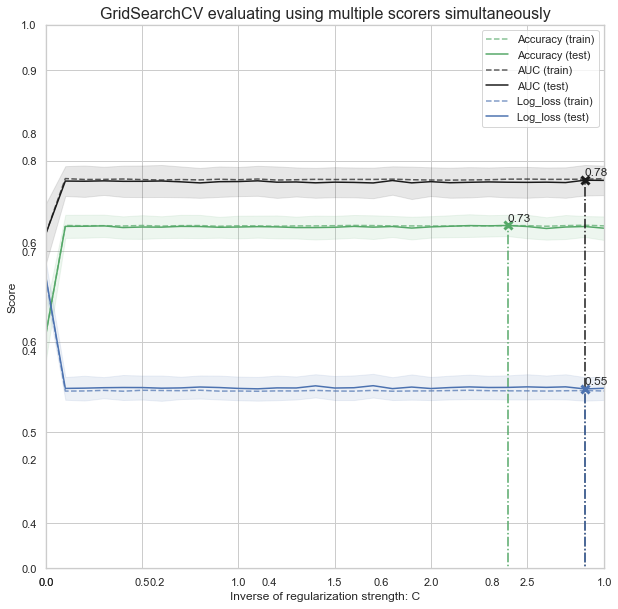

In [78]:
from sklearn.model_selection import GridSearchCV

X = final_train[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

<a id="t4.4."></a>
## 4.4. GridSearchCV evaluating using multiple scorers, RepeatedStratifiedKFold and pipeline for preprocessing simultaneously

We can applied many tasks together for more in-depth evaluation like gridsearch using cross-validation based on k-folds repeated many times, that can be scaled or no with respect to many scorers and tunning on parameter for a given estimator!  

best params: Pipeline(steps=[('scale', StandardScaler(with_mean=False, with_std=False)),
                ('clf', LogisticRegression(C=0.30001000000000005))])
best params: {'clf__C': 0.30001000000000005}
best score: 0.7278139020471193


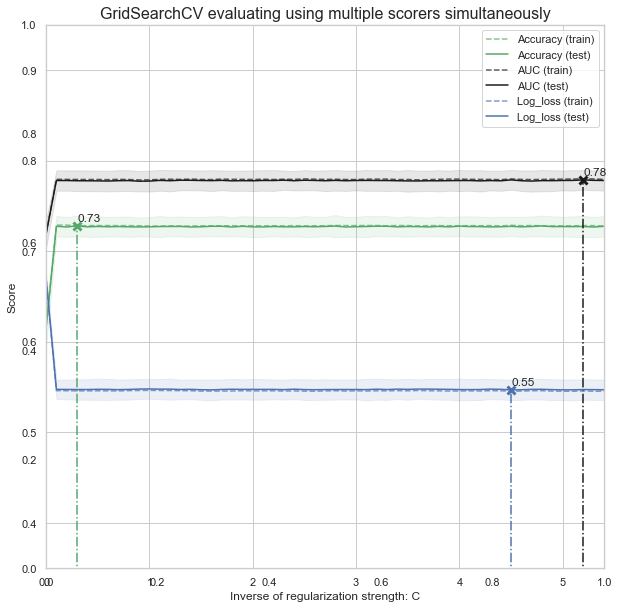

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

#Define simple model
###############################################################################
C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#Simple pre-processing estimators
###############################################################################
std_scale = StandardScaler(with_mean=False, with_std=False)
#std_scale = StandardScaler()

#Defining the CV method: Using the Repeated Stratified K Fold
###############################################################################

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

#Creating simple pipeline and defining the gridsearch
###############################################################################

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])

log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_

print('='*20)
print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*20)

plt.figure(figsize=(10, 10))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, C.max()) 
ax.set_ylim(0.35, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_clf__C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

In [80]:
final_test.isnull().sum()

PassengerId                  0
Cabin                        0
Age                          0
Name                         0
TotalExpenditure             0
CryoSleep_False              0
CryoSleep_True               0
VIP_False                    0
VIP_True                     0
Cabin_class_A                0
Cabin_class_B                0
Cabin_class_C                0
Cabin_class_D                0
Cabin_class_E                0
Cabin_class_F                0
Cabin_class_G                0
Cabin_class_T                0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
IsMinor                      0
dtype: int64

In [81]:
import os
os.getcwd()

'/Users/guoda/CodeAcademy 2021-2022/Studies Material/PRACTICE in Python(2022-01-27--)/2022W18_ProjectWorkSpaceshipTitanic ver.3'

In [82]:
Selected_features = ["CryoSleep", "Age","TotalExpenditure","VIP","Cabin_class_A","Cabin_class_B","Cabin_class_C","Cabin_class_D","Cabin_class_E","Cabin_class_F","Cabin_class_G","Cabin_class_T",
       "HomePlanet_Earth","HomePlanet_Europa","HomePlanet_Mars","Destination_55 Cancri e","Destination_PSO J318.5-22","Destination_TRAPPIST-1e"]

In [83]:
final_test['Transported_prediction'] = log_clf.predict(final_test[Selected_features])
final_test['PassengerId'] = test_df['PassengerId']
final_test['Actual_transported']=train_df['Transported']

prediction_results = final_test[['PassengerId','Transported_prediction','Actual_transported']]
prediction_results.to_csv("prediction_results_final_test.csv", index=False)
prediction_results.info()

KeyError: "['CryoSleep', 'VIP'] not in index"

In [ ]:
final_train['Transported_prediction'] = log_clf.predict(final_train[Selected_features])
# final_train['PassengerId'] = final_train['PassengerId']
final_train['Actual_transported']=final_train['Transported']
final_train

prediction_results = final_train[['PassengerId','Transported_prediction','Actual_transported']]
prediction_results.to_csv("prediction_results_final_train.csv", index=False)
prediction_results.info()

In [ ]:
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)

In [ ]:
final_test[final_test["Age"]==59.0].sort_values(by=["Actual_transported"], ascending=False)

In [ ]:
final_train[(final_train["Age"]==14.0) & (final_train["TotalExpenditure"]==657)].sort_values(by=["Actual_transported"], ascending=False)

In [ ]:
final_test['Transported_prediction'] = log_clf.predict(final_test[Selected_features])
# final_train['PassengerId'] = final_train['PassengerId']
final_test['Actual_transported']=final_test['Transported_prediction']
final_train

prediction_results = final_train[['PassengerId','Transported_prediction','Actual_transported']]
prediction_results.to_csv("Test_prediction_results.csv", index=False)
prediction_results.tail()